In [31]:
import importlib
import utilsHannes as utilsH

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper

from nuscenes.eval.prediction.splits import get_prediction_challenge_split

import matplotlib.pyplot as plt
%matplotlib inline


In [32]:
importlib.reload(utilsH)

version = "v1.0-mini"
DATAROOT = "data/sets/nuscenes"
subset = "mini_train"
seconds_of_history_used = 2.0
mini_train = get_prediction_challenge_split('mini_train', dataroot=DATAROOT)
data_set = mini_train

# --------------------------------------------------------------------------
# Use get_and_format_data as a wrapping function:
img_list, img_tensor_list, agent_state_vector_list, future_xy_local_list = utilsH.get_and_format_data(version, DATAROOT, subset, seconds_of_history_used)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 3.544 seconds.
Reverse indexing ...
Done reverse indexing in 0.3 seconds.


In [33]:
# importlib.reload(utilsH)

# version = "v1.0-mini"
# DATAROOT = "data/sets/nuscenes"
# subset = "mini_train"

# # --------------------------------------------------------------------------
# # Use the sub-functions directly:
# nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)
# mini_train = get_prediction_challenge_split('mini_train', dataroot=DATAROOT)
# helper = PredictHelper(nuscenes)

# # # FOR SMALL TEST:
# # data_set = mini_train[:50]
# # else:
# data_set = mini_train

# seconds_of_history_used = 1.5

# instance_token_list, sample_token_list = utilsH.get_instance_tokens_and_sample_tokens(data_set)

# instance_token_list, sample_token_list = utilsH.remove_short_sequences(seconds_of_history_used, instance_token_list, sample_token_list)

# instance_token_list, sample_token_list = utilsH.extract_one_instance_per_sequence(seconds_of_history_used, instance_token_list, sample_token_list)

# img_list, agent_state_vector_list, future_xy_local_list = utilsH.get_data_and_ground_truth(nuscenes, helper, seconds_of_history_used, instance_token_list, sample_token_list)

# img_tensor_list = utilsH.create_img_tensor(img_list)

data_set at index 4: bc38961ca0ac4b14ab90e547ba79fbb6_f1e3d9d08f044c439ce86a2d6fcca57b
agent_state_vector at index 4: tensor([[9.0783, 0.6008, 0.0000]])
future_xy_local at index 4:
[[-0.29354777  3.34668937]
 [-0.42006699  8.70861233]
 [-0.5467473  13.82791425]
 [-0.75323613 18.61060422]
 [-0.94647532 23.12413727]
 [-1.0315138  27.55555696]
 [-1.32069127 31.75470037]
 [-1.67371225 35.29721603]
 [-1.97815124 37.85282298]
 [-2.43699988 40.6379025 ]
 [-2.90035247 42.74170035]
 [-3.48701218 45.07576619]]


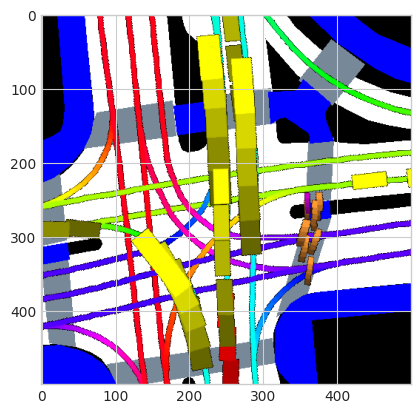

In [34]:
# Test objects for specific index

test_index = 4 #Den ser ut att bryta mellan 108 och 109 exempelvis

print(f"data_set at index {test_index}: {data_set[test_index]}")
# print(f"instance_token_list at index {test_index}: {instance_token_list[test_index]}")
# print(f"sample_token_list at index {test_index}: {sample_token_list[test_index]}")
plt.imshow(img_list[test_index])
print(f"agent_state_vector at index {test_index}: {agent_state_vector_list[test_index]}")
print(f"future_xy_local at index {test_index}:")# {future_xy_local_list[test_index]}")
print(future_xy_local_list[test_index])

In [35]:
importlib.reload(utilsH)

## Create video

# output_filename = 'test_output_video_2fps_dt2_50.avi'
output_filename = f'test_output_video_2fps_length_{len(img_list)}.avi'#Daniel
utilsH.create_video(img_list, output_filename, fps=2)

In [36]:
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet
import torch

backbone = ResNetBackbone('resnet50')
mtp = MTP(backbone, num_modes=2)

# Note that the value of num_modes depends on the size of the lattice used for CoverNet.
covernet = CoverNet(backbone, num_modes=64)

In [43]:
test_index = 45

logits = covernet(img_tensor_list[test_index], agent_state_vector_list[test_index])

sofmaxy = torch.nn.Softmax(dim=1)
outputy = sofmaxy(logits)
print(torch.sum(outputy).item())
print(outputy.detach())

1.0000001192092896
tensor([[0.0079, 0.0141, 0.0204, 0.0124, 0.0078, 0.0207, 0.0136, 0.0239, 0.0241,
         0.0127, 0.0165, 0.0078, 0.0137, 0.0126, 0.0107, 0.0261, 0.0137, 0.0179,
         0.0138, 0.0076, 0.0107, 0.0190, 0.0218, 0.0244, 0.0149, 0.0104, 0.0233,
         0.0232, 0.0170, 0.0170, 0.0084, 0.0110, 0.0107, 0.0145, 0.0220, 0.0155,
         0.0110, 0.0112, 0.0203, 0.0136, 0.0131, 0.0089, 0.0177, 0.0143, 0.0148,
         0.0183, 0.0236, 0.0155, 0.0132, 0.0205, 0.0162, 0.0133, 0.0159, 0.0143,
         0.0171, 0.0121, 0.0196, 0.0117, 0.0118, 0.0155, 0.0225, 0.0157, 0.0147,
         0.0217]])


In [49]:
import pickle

#Epsilon is the amount of coverage in the set, 
#i.e. a real world trajectory is at most 8 meters from a trajectory in this set
#We released the set for epsilon = 2, 4, 8. Consult the paper for more information
#on how this set was created

#PATH_TO_EPSILON_8_SET = "/data/sets/nuscenes-prediction-challenge-trajectory-sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl"
PATH_TO_EPSILON_8_SET = "data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl"
trajectories = pickle.load(open(PATH_TO_EPSILON_8_SET, 'rb'))

#Saved them as a list of lists
trajectories = torch.Tensor(trajectories)

# Hannes kommenterar bort
#Print 5 most likely predictions
# print(trajectories[logits.argsort(descending=True)[:1]])



# Hannes 
newTraj = trajectories[logits.argsort(descending=True)[:1]]
print(newTraj)

tensor([[[[-7.9530e-02,  2.8561e+00],
          [-2.9207e-01,  6.2787e+00],
          [-7.1361e-01,  9.9703e+00],
          ...,
          [-1.1679e+01,  3.7378e+01],
          [-1.4354e+01,  4.0899e+01],
          [-1.7089e+01,  4.4090e+01]],

         [[-2.8011e-01,  3.3396e+00],
          [-8.5391e-01,  6.6029e+00],
          [-1.7871e+00,  9.8274e+00],
          ...,
          [-2.4038e+01,  3.4449e+01],
          [-2.8810e+01,  3.8055e+01],
          [-3.3998e+01,  4.1688e+01]],

         [[ 4.6056e-02,  3.6988e+00],
          [ 3.4553e-01,  6.9963e+00],
          [ 8.5752e-01,  1.0285e+01],
          ...,
          [ 1.0942e+01,  2.8339e+01],
          [ 1.3190e+01,  3.0253e+01],
          [ 1.5600e+01,  3.1961e+01]],

         ...,

         [[-2.4342e-02,  6.0260e+00],
          [-1.0404e-01,  1.1295e+01],
          [-9.2170e-02,  1.7083e+01],
          ...,
          [ 3.6829e-01,  5.7070e+01],
          [ 2.6024e-01,  6.3046e+01],
          [ 7.5568e-02,  6.9022e+01]],

     

Shape of set of all trajectories = (64, 12, 2)


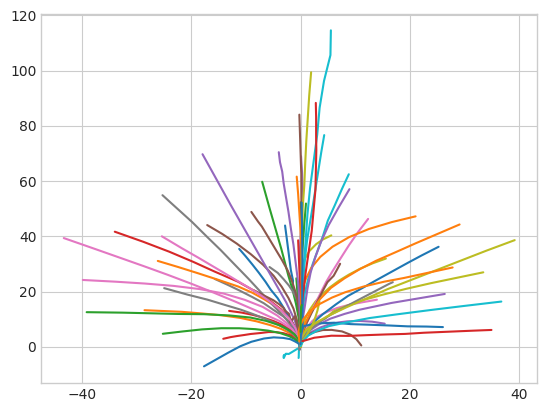

predictedProbabilities = [0.00758479 0.00780478 0.00782065 0.00788555 0.00838624 0.00890815
 0.0103852  0.01069965 0.01070572 0.01073104 0.01104812 0.0110496
 0.01122659 0.01167684 0.01183179 0.01212808 0.01241349 0.01260684
 0.01266361 0.01308195 0.01324861 0.01330583 0.01358296 0.01363397
 0.0136752  0.01373172 0.01383515 0.01410547 0.01427637 0.01428975
 0.01452444 0.01471141 0.01475233 0.01493007 0.01545375 0.01548076
 0.01549439 0.01571712 0.01587138 0.01622762 0.01650768 0.01701171
 0.01704585 0.01705051 0.01771743 0.0178619  0.01828428 0.01903394
 0.01963329 0.02034883 0.02039634 0.02050722 0.02070443 0.02165751
 0.02175522 0.02197291 0.02250906 0.02319447 0.02330834 0.02356313
 0.02392132 0.02406921 0.02439692 0.0260616 ]
predictedProbabilitiesIndices = [19 11  4  0 30 41 25 32 14 20 31 36 37 57 58 55  3 13  9 40 48 51 39  6
 12 16 18  1 43 53 33 62 44 24 47 59 35 61 52 50 10 28 29 54 42 17 45 21
 56 38  2 49  5 63 22 34 60 27 26 46  7  8 23 15]
topProbabilitiesIndices = [15 23

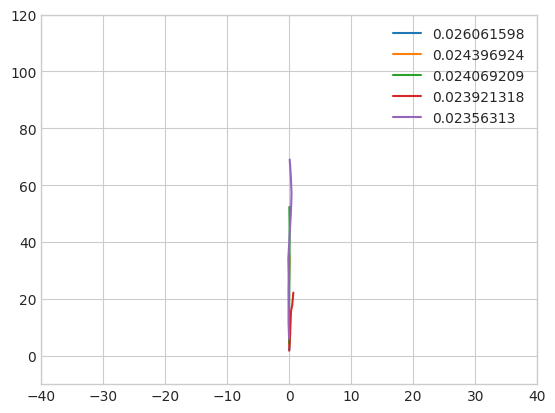

In [57]:
# Hannes cell
import numpy as np

### Choose which trajectory sets to use 
# with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_2.pkl', 'rb') as f:
#     data = pickle.load(f)
# with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_4.pkl', 'rb') as f:
#     data = pickle.load(f)
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    data = pickle.load(f)

allTrajectories = np.array(data)
print(f"Shape of set of all trajectories = {allTrajectories.shape}")

### Plot all trajectories
modes = np.arange(allTrajectories.shape[0])
timesteps = np.arange(12) # 12 timesteps (which is maximum), can be reduced
for mode in modes:
    plt.plot(allTrajectories[mode,timesteps,0],allTrajectories[mode,timesteps,1])
plt.show()


### Plot selected trajectories
numbersOfDisplayedProbabilities = 5
# topPredictedTrajectories = allTrajectories[logits.argsort(descending=True)[0][:numbersOfDisplayedProbabilities]] # Choose top 5 predictions
topPredictedTrajectories = allTrajectories[outputy.argsort(descending=True)[0][:numbersOfDisplayedProbabilities]] # Choose top 5 predictions

# print(allTrajectories)
# print(f"outputy.argsort(descending=True)[0][:numbersOfDisplayedProbabilities] = {outputy.argsort(descending=True)[0][:numbersOfDisplayedProbabilities]}")
# print(topPredictedTrajectories)
# predictedProbabilities = outputy[0][outputy.argsort(descending=True)[0][:5]]

# tmpOutputy = outputy.detach().clone()
# print(tmpOutputy)
# predictedProbabilities = []
# for topPrediction in range(numbersOfDisplayedProbabilities):
#     predictedProbabilitiesIndex = [tmpOutputy.argmax()]
#     print(predictedProbabilitiesIndex)
#     tmpOutputy[0][predictedProbabilitiesIndex] = 0
#     predictedProbabilities.append(predictedProbabilitiesIndex)

## TO GET INDICES
outputyValues = outputy.detach().numpy().squeeze()
predictedProbabilitiesIndices = np.argsort(outputyValues)
predictedProbabilities = outputyValues[predictedProbabilitiesIndices]
# topProbabilitiesIndices = predictedProbabilities[0][::-1][0:numbersOfDisplayedProbabilities]
topProbabilitiesIndices = predictedProbabilitiesIndices[::-1][0:numbersOfDisplayedProbabilities]
# predictedProbabilities = outputy.argsort(descending=True)
# topProbabilities = predictedProbabilities[0][0:5]
# topProbabilities = topProbabilitiesIndices

# print(outputyValues)
## TO GET VALUES 
topProbabilities = []
for index in topProbabilitiesIndices:
    topProbabilities.append(outputyValues[index])


# print(f"outputy = {outputy}")
print(f"predictedProbabilities = {predictedProbabilities}")
print(f"predictedProbabilitiesIndices = {predictedProbabilitiesIndices}")
print(f"topProbabilitiesIndices = {topProbabilitiesIndices}")
print(f"topProbabilities = {topProbabilities}")
print(f"Shape of top predicted trajectories = {topPredictedTrajectories.shape}")
modes2 = np.arange(topPredictedTrajectories.shape[0])
# timesteps = np.arange(12)
for mode in modes2:
    plt.plot(allTrajectories[mode,timesteps,0],allTrajectories[mode,timesteps,1])
plt.ylim([-10,120])
plt.xlim([-40,40])
# plt.legend(["1th prediction", "2nd prediction", "3rd prediction", "4th prediction", "5th prediction"])
plt.legend(topProbabilities)
plt.show()


# Test line for pushing, again


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers of your neural network here
        # Example:
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Define the forward pass of your neural network
        # Example:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network
net = Net()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Load and preprocess your data (e.g., using torchvision)

# Training loop
for epoch in range(epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs and labels from the data loader
        inputs, labels = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = net(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Print the average loss for this epoch
    print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1):.4f}')

print('Finished training')
